In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mra

In [2]:
plt.rcParams['text.usetex'] = True
np.random.seed(123)

# Create parameters

In [3]:
rho = 1.
num_points = [10, 50]
eps_sublevel = percent = 0.1

m = num_agents = 100
n = 25

filename = "ot_N%s_%s_n%d"%(",".join(list(map(str, num_points))), eps_sublevel, num_agents)

In [4]:
C, a, A_eq, b_eq, A_ineq, b_ineq, volumes, mean = mra.ot_data(m, n)

In [5]:
b_norm = (np.linalg.norm(b_eq)**2 + np.linalg.norm(b_ineq)**2)**0.5

# CVXPY centralized solution

In [6]:
true_x, true_f, true_lamb = mra.centralized_solution_ot(C, a, A_eq, b_eq, A_ineq, b_ineq)
print(f"{true_f=}")

true_f=1.1519520887311967


In [7]:
(true_lamb.max() - true_lamb.min()) / true_lamb.max()

1.5730112050161082

In [8]:
true_lamb.shape, true_x.shape

((50, 1), (2500, 1))

In [9]:
fun_agents_eps = []
fun_agents_noisy_y = []

for i in range(num_agents):
    fun_agents_eps += [lambda lamb_k, K, i=i: mra.ot_query_multiple_actions(lamb_k, C[i:i+1].T, a[i, 0], vol_i=volumes[i, 0], 
                                                                       eps_sublevel=eps_sublevel, num_points=K)]
    fun_agents_noisy_y += [lambda lamb_k, K, i=i: mra.ot_query_multiple_actions_noisy_prices(lamb_k, C[i:i+1].T, a[i, 0], vol_i=volumes[i, 0], 
                                                                       percent=percent, num_points=K)]


fun_obj_val = lambda x_k: mra.ot_obj_value(x_k, C, a, b_eq)

# Localization

In [10]:
price_min, price_max = mra.ot_prime_initial_bound(true_lamb, A_eq, b_eq, A_ineq, b_ineq)

alpha = 1 # proximal term coefficient
N = num_agents
primal_var_size = A_eq.shape[1]

In [11]:
all_results_eps = {}
all_results_noisy_y = {}
for K_i in num_points:
    print(f"{K_i=}")
    all_results_eps[K_i]  = mra.price_localization_primal_recovery(fun_agents_eps, fun_obj_val, primal_var_size, A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=200, A_eq=A_eq, b_eq=b_eq,
                                                            method="accpm_l2", true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)[0]


    all_results_noisy_y[K_i]  = mra.price_localization_primal_recovery(fun_agents_noisy_y, fun_obj_val, primal_var_size, 
                                                                                                      A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=200, A_eq=A_eq, b_eq=b_eq,
                                                            method="accpm_l2", true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)[0]

K_i=10
epoch=0, f_prec[-1]=1.09, f_xk[-1]=0.80, viol_prec=1.8213E+00, viol_xk=6.7878E+00, lamb_rel_diff=0.0000E+00, dist_x_bar_x[-1]=9.2897E-01
epoch=50, f_prec[-1]=1.22, f_xk[-1]=1.18, viol_prec=7.7127E-03, viol_xk=1.0979E+00, lamb_rel_diff=6.8387E-02, dist_x_bar_x[-1]=6.5578E-01
epoch=100, f_prec[-1]=1.22, f_xk[-1]=1.12, viol_prec=1.4033E-03, viol_xk=1.1624E+00, lamb_rel_diff=3.6454E-02, dist_x_bar_x[-1]=7.0152E-01
epoch=150, f_prec[-1]=1.23, f_xk[-1]=1.14, viol_prec=1.1445E-02, viol_xk=1.0747E+00, lamb_rel_diff=2.1390E-02, dist_x_bar_x[-1]=7.1096E-01
epoch=199, f_prec[-1]=1.22, f_xk[-1]=1.14, viol_prec=9.1958E-04, viol_xk=1.0291E+00, lamb_rel_diff=1.9529E-02, dist_x_bar_x[-1]=7.3696E-01
epoch=0, f_prec[-1]=0.88, f_xk[-1]=0.80, viol_prec=4.1947E+00, viol_xk=6.7878E+00, lamb_rel_diff=0.0000E+00, dist_x_bar_x[-1]=7.6846E-01
epoch=50, f_prec[-1]=1.16, f_xk[-1]=1.18, viol_prec=6.9560E-01, viol_xk=1.0979E+00, lamb_rel_diff=6.8387E-02, dist_x_bar_x[-1]=5.4053E-01
epoch=100, f_prec[-1]=1.17

In [12]:
K_i = min(num_points)
if len(all_results_noisy_y[K_i]["subopt_xk"]) > len(all_results_eps[K_i]["subopt_xk"]):
    all_res = all_results_noisy_y[K_i]
else:
    all_res = all_results_eps[K_i]

In [14]:
for i, K_i in enumerate(num_points):
      print(np.array(all_res["viol_primal_xk"])[-1] / b_norm,
      "sub_eps", np.array(all_results_eps[K_i]["viol_primal_mra_xk"])[-1] / b_norm,
      "noisy_y", np.array(all_results_noisy_y[K_i]["viol_primal_mra_xk"])[-1] / b_norm)

0.9285741211513757 sub_eps 6.158983973125032e-09 noisy_y 0.07774630451999193
0.9285741211513757 sub_eps 1.6311329523826088e-09 noisy_y 2.8643446465075064e-14


In [ ]:
import pickle

with open(f"results/{filename}_dict.pkl", "wb") as file:
    pickle.dump({"eps":all_results_eps, "noisy_y":all_results_noisy_y}, file)

In [7]:
import pickle

# with open(f"results/{filename}_dict.pkl", "wb") as file:
#     pickle.dump({"eps":all_results_eps, "noisy_y":all_results_noisy_y}, file)
with open(f"results/{filename}_dict.pkl", "rb") as file:
    res = pickle.load(file)
    all_results_eps = res["eps"]
    all_results_noisy_y = res["noisy_y"]
    K_i = min(num_points)
    if len(all_results_noisy_y[K_i]["subopt_xk"]) > len(all_results_eps[K_i]["subopt_xk"]):
        all_res = all_results_noisy_y[K_i]
    else:
        all_res = all_results_eps[K_i]
# res["eps"].keys()

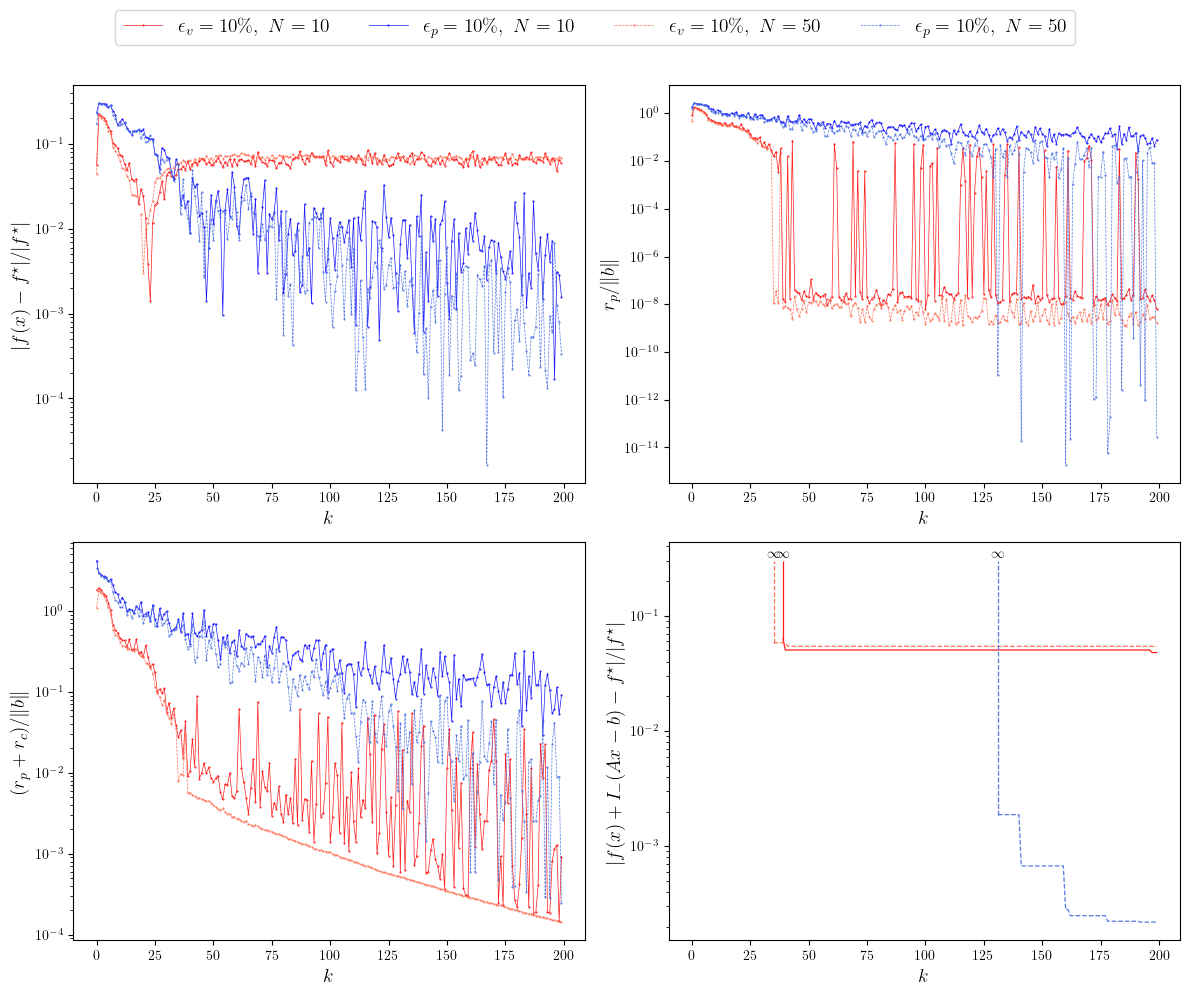

In [8]:
mra.plot_N_all_metrics_4x(all_results_eps, all_results_noisy_y, eps_sublevel, true_f, 
                                b_norm, num_points, filename)